In [1]:
import torch

import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torchvision.models as models

import sys
import math

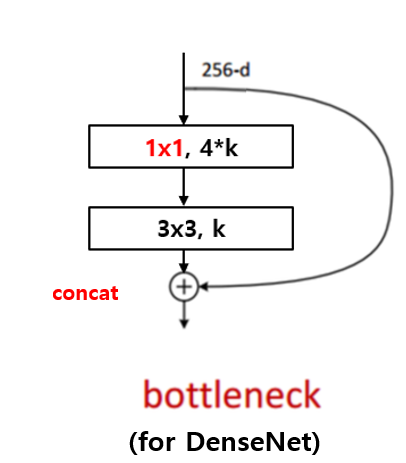

In [2]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels,growthRate):
        super(Bottleneck,self).__init__()
        interChannels = 4*growthRate
        self.bn1=nn.BatchNorm2d(nChannels)
        self.conv1=nn.Conv2d(nChannels, interChannels,kernel_size=1,
                            bias=False)
        self.bn2=nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)
    def forward(self,x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

# DenseNet Transition
## Image Size, Depth => Half 
### BatchNorm, ReLU, 1X1Conv, 2X2 average pooling

In [3]:
class Transition(nn.Module): # 반으로 줄여주는 작업임.
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

# Basic DenseNet
## GrowthRate=12, Depth=100, Reduction=0.5, Bottleneck=True, nClass=10

In [4]:
class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3 # 만약 depth가 100이라면 32
        if bottleneck:
            nDenseBlocks //= 2 # Bottleneck이 있다면  16

        nChannels = 2*growthRate # growthRate 12
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
                               bias=False)
        # 1, 24, 50, 50
        
        #nDenseBlock => 16(Bottleneck)
        #nChannel => 24
        #growthRath => 12
        # 16*12=192
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        # 1, 216, 50, 50
        # 12*18 => 12 == growthRath 
        nChannels += nDenseBlocks*growthRate
        # 24 + 192 =>nChannels
        #print(nChannels)
        nOutChannels = int(math.floor(nChannels*reduction)) #math.floor는 소수점 내림.
        # nOutChannels => 108
        self.trans1 = Transition(nChannels, nOutChannels)
        # 1, 108, 25, 25 반반으로 짜름

        nChannels = nOutChannels
        # 1, 108, 25, 25 => x 
        # nChannels => 108
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        # 1, 300, 25, 25
        # 108 + 12*16 = > 300
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)
        # 1, 150, 12 ,12

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        # 1, 342, 12, 12
        # 192를 계속 더해줌 Tip!
        # 150+192=>342
        nChannels += nDenseBlocks*growthRate
        # print(nChannels)
        # nChannels => 342
        

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        # layer의 초기화 
        for m in self.modules():
            if isinstance(m, nn.Conv2d): # m이 nn.Conv2d이면
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # n=> size
                m.weight.data.normal_(0, math.sqrt(2. / n))
                #zero-mean Gaussian distribution Standard deviation
                
                #print(m.weight.data)
                # 가중치 초기화
            elif isinstance(m, nn.BatchNorm2d): # m이 nn.BatchNorm2d이면
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                # bias => 0
            elif isinstance(m, nn.Linear): # m이 nn.Linear이면
                m.bias.data.zero_()
                # bias=> 0
        # xavier method => initial differnece thesis ReLu/PReLU 제외
        # delving deep into rectifiers: surpassing human level performance on imagenet classification

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        # 1, 24, 50, 50
        out = self.trans1(self.dense1(out))
        # 1, 216, 50, 50
        # 1, 108, 25, 25
        out = self.trans2(self.dense2(out))
        # 1, 300, 25, 25
        # 1, 150, 12 ,12
        out = self.dense3(out)
        # 1, 342, 12 ,12
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        # avg_pool2d out => 1, 342, 1, 1
        out = F.log_softmax(self.fc(out))
        return out